## Fine Tuning spaCy NER Model to identify food products

I'm building an app that recognizes entities when having a conversation. 
To do this, I'll be making use of spaCy for natural language processing (NLP).
In this notebook, we'll be training spaCy to identify FOOD entities from a body of text - a task known as named-entity recognition (NER). 
If all goes well, we should be able to identify the foods from the following sentences:

- Can I have a hamburger and fries  
- I want a taco with tabasco and nachos
- I would like to have rice  with curry and potatoes

spaCy has a NER accuracy of 85.85%, so something in that range would be nice for our FOOD entities.

Approach
We'll use the following approach:

- Generate sentences with FOOD entities.
- Generate sentences with existing spaCy entities to avoid the catastrophic forgetting problem.
- Train spaCy NER with the existing entities and the custom FOOD entities. Stir until good enough.

Results
Category	     |Results
-----------------|----------
FOOD Entities	 |97.47%
Existing Entities|78.17%

In [42]:
import en_core_web_lg
import pandas as pd
import re
import random
import spacy
from spacy.util import minibatch, compounding
import warnings
import matplotlib.pyplot as plt
from spacy.training import Example

### Gathering Food Data
We'll be using food data from the [USDA's Branded Food's dataset.](https://fdc.nal.usda.gov/download-datasets.html)

In [19]:
# read in the food csv file
food_df = pd.read_csv("./food_data/food.csv")

# print row and column information
food_df.head()

,fdc_id,data_type,description,food_category_id,publication_date
0,1105904,branded_food,WESSON Vegetable Oil 1 GAL,NaN,2020-11-13
1,1105905,branded_food,SWANSON BROTH BEEF,NaN,2020-11-13
2,1105906,branded_food,CAMPBELL'S SLOW KETTLE SOUP CLAM CHOWDER,NaN,2020-11-13
3,1105907,branded_food,CAMPBELL'S SLOW KETTLE SOUP CHEESE BROCCOLI,NaN,2020-11-13
4,1105908,branded_food,SWANSON BROTH CHICKEN,NaN,2020-11-13


### Cause there are more rows, so we will:

- Remove foods with special characters (+,&, !, etc.).
- Filter out foods containing more than 3 words.

In [21]:
# remove foods with special characters, lowercase and extract results from "description" column
foods = food_df[food_df["description"].str.contains("[^a-zA-Z ]") == False]["description"].apply(lambda food: food.lower())

# filter out foods with more than 3 words, drop any duplicates
foods = foods[foods.str.split().apply(len) <= 3].drop_duplicates()

# print the remaining size
foods.size

41009

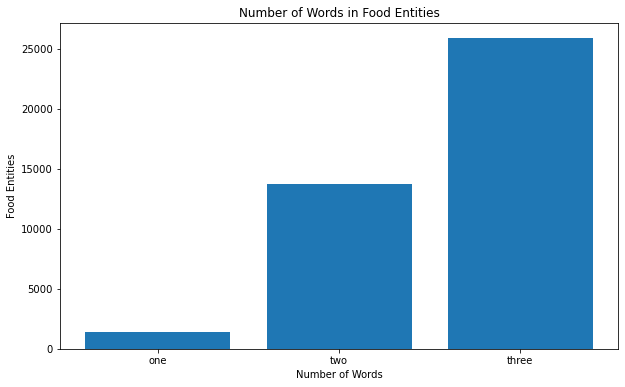

In [22]:
# find one-worded, two-worded and three-worded foods
one_worded_foods = foods[foods.str.split().apply(len) == 1]
two_worded_foods = foods[foods.str.split().apply(len) == 2]
three_worded_foods = foods[foods.str.split().apply(len) == 3]

# create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([1, 2, 3], [one_worded_foods.size, two_worded_foods.size, three_worded_foods.size])

# label the x-axis instances
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["one", "two", "three"])

# set the title and the xy-axis labels
plt.title("Number of Words in Food Entities")
plt.xlabel("Number of Words")
plt.ylabel("Food Entities")

# display the plot
plt.show()

Because the majority of our food entities are multi-worded, spaCy would develop a bias for multi-worded foods. If we look back to our example of grilled cheese, it's not a big deal if spaCy identifies cheese instead of grilled cheese. It is a big deal if spaCy fails to identify cheese at all.

So let's filter the dataset further, such that 45% are one-worded foods, 30% are two-worded foods, and 25% are three-worded foods.

In [23]:
# total number of foods
total_num_foods = round(one_worded_foods.size / 45 * 100)

# shuffle the 2-worded and 3-worded foods since we'll be slicing them
two_worded_foods = two_worded_foods.sample(frac=1)
three_worded_foods = three_worded_foods.sample(frac=1)

# append the foods together 
foods = one_worded_foods.append(two_worded_foods[:round(total_num_foods * 0.30)]).append(three_worded_foods[:round(total_num_foods * 0.25)])

# print the resulting sizes
for i in range(3):
    print(f"{i+1}-worded food entities:", foods[foods.str.split().apply(len) == i + 1].size)


1-worded food entities: 1378
2-worded food entities: 919
3-worded food entities: 766


## Train test Split

In [45]:
food_templates = [
    "I want a {}",
    "I would like to have a {}",
    "Imma need a {}",
    "Can I have a {}",
    "I want a {} with {}",
    "I would like to have a {} with {}",
    "Imma need a {} with {}",
    "Can I have a {} with {}",
    "I want a {}, {}",
    "I would like to have a {}, {}",
    "Imma need a {}, {}",
    "Can I have a {},  {}",
    "I want a {} with {} and {}",
    "I would like to have a {} with {} and {}",
    "Imma need a {} with {} and {}",
    "Can I have a {} with {} and {}",
]

In [46]:
# create dictionaries to store the generated food combinations. Do note that one_food != one_worded_food. one_food == "barbecue sauce", one_worded_food == "sauce"
TRAIN_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

TEST_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

# one_food, two_food, and three_food combinations will be limited to 167 sentences
FOOD_SENTENCE_LIMIT = 167

# helper function for deciding what dictionary and subsequent array to append the food sentence on to
def get_food_data(count):
    return {
        1: TRAIN_FOOD_DATA["one_food"] if len(TRAIN_FOOD_DATA["one_food"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["one_food"],
        2: TRAIN_FOOD_DATA["two_foods"] if len(TRAIN_FOOD_DATA["two_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["two_foods"],
        3: TRAIN_FOOD_DATA["three_foods"] if len(TRAIN_FOOD_DATA["three_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["three_foods"],
    }[count]

# the pattern to replace from the template sentences
pattern_to_replace = "{}"

# shuffle the data before starting
foods = foods.sample(frac=1)

# the count that helps us decide when to break from the for loop
food_entity_count = foods.size - 1

# start the while loop, ensure we don't get an index out of bounds error
while food_entity_count >= 2:
    entities = []

    # pick a random food template
    sentence = food_templates[random.randint(0, len(food_templates) - 1)]

    # find out how many braces "{}" need to be replaced in the template
    matches = re.findall(pattern_to_replace, sentence)

    # for each brace, replace with a food entity from the shuffled food data
    for match in matches:
        food = foods.iloc[food_entity_count]
        food_entity_count -= 1

        # replace the pattern, but then find the match of the food entity we just inserted
        sentence = sentence.replace(match, food, 1)
        match_span = re.search(food, sentence).span()

        # use that match to find the index positions of the food entity in the sentence, append
        entities.append((match_span[0], match_span[1], "FOOD"))

    # append the sentence and the position of the entities to the correct dictionary and array
    get_food_data(len(matches)).append((sentence, {"entities": entities}))

In [47]:
# print the number of food sentences, as well as an example sentence
for key in TRAIN_FOOD_DATA:
    print("{} {} sentences: {}".format(len(TRAIN_FOOD_DATA[key]), key, TRAIN_FOOD_DATA[key][0]))

167 one_food sentences: ('Can I have a coffee roasters', {'entities': [(13, 28, 'FOOD')]})
167 two_foods sentences: ('Imma need a cheesecake platter, kiwi', {'entities': [(12, 30, 'FOOD'), (32, 36, 'FOOD')]})
167 three_foods sentences: ('I would like to have a fruit tray with zucchini squash and whole italian sub', {'entities': [(23, 33, 'FOOD'), (39, 54, 'FOOD'), (59, 76, 'FOOD')]})


In [48]:
for key in TEST_FOOD_DATA:
    print("{} {} items: {}".format(len(TEST_FOOD_DATA[key]), key, TEST_FOOD_DATA[key][0]))

194 one_food items: ('I want a masterpieces', {'entities': [(9, 21, 'FOOD')]})
571 two_foods items: ('I want a cured pork longaniza, general tso chicken', {'entities': [(9, 29, 'FOOD'), (31, 50, 'FOOD')]})
241 three_foods items: ('I want a asian yogurt with bauernwurst and classic enriched buns', {'entities': [(9, 21, 'FOOD'), (27, 38, 'FOOD'), (43, 64, 'FOOD')]})


# Generating Revision Data

As mentioned in the overview, we also need to generate sentences that contain spaCy entities. This helps us avoid the situation where the NER model is able to identify the FOOD entities, but forgets how to classify entities like DAT or ORG.

## Preparing the revision data

In [30]:
# read in the revision data (just used a random article dataset from a different course I had taken)
npr_df = pd.read_csv("npr.csv")

# print row and column information
npr_df.head()

,Article
0,"In the Washington of 2016, even when the polic..."
1,Donald Trump has used Twitter — his prefe...
2,Donald Trump is unabashedly praising Russian...
3,"Updated at 2:50 p. m. ET, Russian President Vl..."
4,"From photography, illustration and video, to d..."


In [31]:
# create an nlp object as we'll use this to seperate the sentences and identify existing entities
nlp = en_core_web_lg.load()

In [32]:
revision_texts = []

# convert the articles to spacy objects to better identify the sentences. Disabled unneeded components. # takes ~ 4 minutes
for doc in nlp.pipe(npr_df["Article"][:6000], batch_size=30, disable=["tagger", "ner"]):
    for sentence in doc.sents:
        if  40 < len(sentence.text) < 80:
            # some of the sentences had excessive whitespace in between words, so we're trimming that
            revision_texts.append(" ".join(re.split("\s+", sentence.text, flags=re.UNICODE)))

D:\miniconda3\envs\pdp\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [33]:
revisions = []

# Use the existing spaCy model to predict the entities, then append them to revision
for doc in nlp.pipe(revision_texts, batch_size=50, disable=["tagger", "parser"]):
    
    # don't append sentences that have no entities
    if len(doc.ents) > 0:
        revisions.append((doc.text, {"entities": [(e.start_char, e.end_char, e.label_) for e in doc.ents]}))

In [34]:
# print an example of the revision sentence
print(revisions[0][0])

# print an example of the revision data
print(revisions[0][1])

And in that sense, this year shows little sign of ending on Dec. 31.
{'entities': [(19, 28, 'DATE'), (60, 67, 'DATE')]}


In [35]:
# create arrays to store the revision data
TRAIN_REVISION_DATA = []
TEST_REVISION_DATA = []

# create dictionaries to keep count of the different entities
TRAIN_ENTITY_COUNTER = {}
TEST_ENTITY_COUNTER = {}

# This will help distribute the entities (i.e. we don't want 1000 PERSON entities, but only 80 ORG entities)
REVISION_SENTENCE_SOFT_LIMIT = 100

# helper function for incrementing the revision counters
def increment_revision_counters(entity_counter, entities):
    for entity in entities:
        label = entity[2]
        if label in entity_counter:
            entity_counter[label] += 1
        else:
            entity_counter[label] = 1

random.shuffle(revisions)
for revision in revisions:
    # get the entities from the revision sentence
    entities = revision[1]["entities"]

    # simple hack to make sure spaCy entities don't get too one-sided
    should_append_to_train_counter = 0
    for _, _, label in entities:
        if label in TRAIN_ENTITY_COUNTER and TRAIN_ENTITY_COUNTER[label] > REVISION_SENTENCE_SOFT_LIMIT:
            should_append_to_train_counter -= 1
        else:
            should_append_to_train_counter += 1

    # simple switch for deciding whether to append to train data or test data
    if should_append_to_train_counter >= 0:
        TRAIN_REVISION_DATA.append(revision)
        increment_revision_counters(TRAIN_ENTITY_COUNTER, entities)
    else:
        TEST_REVISION_DATA.append(revision)
        increment_revision_counters(TEST_ENTITY_COUNTER, entities)

In [36]:
TRAIN_ENTITY_COUNTER

{'PERSON': 261,
 'GPE': 183,
 'CARDINAL': 165,
 'ORG': 193,
 'NORP': 129,
 'TIME': 106,
 'DATE': 200,
 'ORDINAL': 111,
 'PRODUCT': 101,
 'QUANTITY': 101,
 'MONEY': 104,
 'FAC': 101,
 'PERCENT': 103,
 'LOC': 103,
 'EVENT': 101,
 'WORK_OF_ART': 103,
 'LAW': 70,
 'LANGUAGE': 58}

In [37]:
TEST_ENTITY_COUNTER

{'PERSON': 11953,
 'ORG': 8200,
 'GPE': 5140,
 'WORK_OF_ART': 305,
 'DATE': 6290,
 'ORDINAL': 970,
 'FAC': 150,
 'TIME': 603,
 'CARDINAL': 4648,
 'NORP': 2311,
 'LOC': 444,
 'PRODUCT': 125,
 'MONEY': 460,
 'QUANTITY': 93,
 'PERCENT': 433,
 'EVENT': 68,
 'LANGUAGE': 16,
 'LAW': 10}

# Training the NER Model

In [49]:
# combine the food training data
TRAIN_FOOD_DATA_COMBINED = TRAIN_FOOD_DATA["one_food"] + TRAIN_FOOD_DATA["two_foods"] + TRAIN_FOOD_DATA["three_foods"]

# print the length of the food training data
print("FOOD", len(TRAIN_FOOD_DATA_COMBINED))

# print the length of the revision training data
print("REVISION", len(TRAIN_REVISION_DATA))

# join and print the combined length
TRAIN_DATA = TRAIN_REVISION_DATA + TRAIN_FOOD_DATA_COMBINED
print("COMBINED", len(TRAIN_DATA))

FOOD 501
REVISION 1475
COMBINED 1976


In [50]:
# add NER to the pipeline and the new label
ner = nlp.get_pipe("ner")
ner.add_label("FOOD")

# get the names of the components we want to disable during training
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

# start the training loop, only training NER
epochs = 30
optimizer = nlp.resume_training()
with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
    warnings.filterwarnings("once", category=UserWarning, module='spacy')
    sizes = compounding(1.0, 4.0, 1.001)
    
    # batch up the examples using spaCy's minibatc
    for epoch in range(epochs):
        examples = TRAIN_DATA
        random.shuffle(examples)
        batches = minibatch(examples, size=sizes)
        losses = {}
        
        for batch in batches:
            texts, annotations = zip(*batch)
            
            example = []
            # Update the model with iterating each text
            for i in range(len(texts)):
                doc = nlp.make_doc(texts[i])
                example.append(Example.from_dict(doc, annotations[i]))

            nlp.update(example, sgd=optimizer, drop=0.35, losses=losses)

        print("Losses ({}/{})".format(epoch + 1, epochs), losses)

D:\miniconda3\envs\pdp\lib\site-packages\spacy\training\iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "I would like to have a stewed tomatoes  with cashe..." with entities "[(23, 39, 'FOOD'), (45, 61, 'FOOD'), (66, 90, 'FOO...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
D:\miniconda3\envs\pdp\lib\site-packages\spacy\training\iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "I want a orzo with pepper steaks  and shoyu chicke..." with entities "[(9, 13, 'FOOD'), (19, 33, 'FOOD'), (38, 57, 'FOOD...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
D:\miniconda3\envs\pdp\lib\site-packages\spacy\training\iob_utils.py:141: UserWarning: [W030] Some entities could not 

Losses (1/30) {'ner': 1744.4680251873408}
Losses (2/30) {'ner': 1303.6553738598473}
Losses (3/30) {'ner': 1113.978699317095}
Losses (4/30) {'ner': 985.6708172091254}
Losses (5/30) {'ner': 957.5738040874099}
Losses (6/30) {'ner': 860.3676341461975}
Losses (7/30) {'ner': 766.7513463772563}
Losses (8/30) {'ner': 722.4744065683285}
Losses (9/30) {'ner': 718.4186806882981}
Losses (10/30) {'ner': 678.054398603244}
Losses (11/30) {'ner': 582.635795398497}
Losses (12/30) {'ner': 558.0896443167587}
Losses (13/30) {'ner': 575.1688132468013}
Losses (14/30) {'ner': 566.3361584044995}
Losses (15/30) {'ner': 601.8568268366527}
Losses (16/30) {'ner': 526.0792745345688}
Losses (17/30) {'ner': 542.5887872962447}
Losses (18/30) {'ner': 533.8633648398055}
Losses (19/30) {'ner': 420.36137952553617}
Losses (20/30) {'ner': 448.5945868204732}
Losses (21/30) {'ner': 415.38239799126535}
Losses (22/30) {'ner': 368.42756756601943}
Losses (23/30) {'ner': 374.2837451244376}
Losses (24/30) {'ner': 506.1999263782777

# Evaluating the Model

In [51]:
# display sentence involving original entities
spacy.displacy.render(nlp("Apple is looking at buying U.K. startup for $1 billion"), style="ent")

In [54]:
# display sentences involving target entity
spacy.displacy.render(nlp("I would like to have chips."), style="ent")
spacy.displacy.render(nlp("I want to have chocolate ice cream."), style="ent")
spacy.displacy.render(nlp("Can I have basmati rice with leaf spinach and cheese"), style="ent")

# Evaluating Food Entities

In [55]:
# dictionary to hold our evaluation data
food_evaluation = {
    "one_food": {
        "correct": 0,
        "total": 0,
    },
    "two_foods": {
        "correct": 0,
        "total": 0
    },
    "three_foods": {
        "correct": 0,
        "total": 0
    }
}

word_evaluation = {
    "1_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "2_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "3_worded_foods": {
        "correct": 0,
        "total": 0
    }
}

# loop over data from our test food set (3 keys in total)
for key in TEST_FOOD_DATA:
    foods = TEST_FOOD_DATA[key]

    for food in foods:
        # extract the sentence and correct food entities according to our test data
        sentence = food[0]
        entities = food[1]["entities"]

        # for each entity, use our updated model to make a prediction on the sentence
        for entity in entities:
            doc = nlp(sentence)
            correct_text = sentence[entity[0]:entity[1]]
            n_worded_food =  len(correct_text.split())

            # if we find that there's a match for predicted entity and predicted text, increment correct counters
            for ent in doc.ents:
                if ent.label_ == entity[2] and ent.text == correct_text:
                    food_evaluation[key]["correct"] += 1
                    if n_worded_food > 0:
                        word_evaluation[f"{n_worded_food}_worded_foods"]["correct"] += 1
                    
                    # this break is important, ensures that we're not double counting on a correct match
                    break
            
            #  increment total counters after each entity loop
            food_evaluation[key]["total"] += 1
            if n_worded_food > 0:
                word_evaluation[f"{n_worded_food}_worded_foods"]["total"] += 1

In [56]:
for key in word_evaluation:
    correct = word_evaluation[key]["correct"]
    total = word_evaluation[key]["total"]

    print(f"{key}: {correct / total * 100:.2f}%")

food_total_sum = 0
food_correct_sum = 0

print("---")
for key in food_evaluation:
    correct = food_evaluation[key]["correct"]
    total = food_evaluation[key]["total"]
    
    food_total_sum += total
    food_correct_sum += correct

    print(f"{key}: {correct / total * 100:.2f}%")

print(f"\nTotal: {food_correct_sum/food_total_sum * 100:.2f}%")

1_worded_foods: 97.01%
2_worded_foods: 98.69%
3_worded_foods: 96.86%
---
one_food: 97.94%
two_foods: 96.67%
three_foods: 98.62%

Total: 97.47%


# Evaluating Existing Entities

In [57]:
# dictionary which will be populated with the entities and result information
entity_evaluation = {}

# helper function to udpate the entity_evaluation dictionary
def update_results(entity, metric):
    if entity not in entity_evaluation:
        entity_evaluation[entity] = {"correct": 0, "total": 0}
    
    entity_evaluation[entity][metric] += 1

# same as before, see if entities from test set match what spaCy currently predicts
for data in TEST_REVISION_DATA:
    sentence = data[0]
    entities = data[1]["entities"]

    for entity in entities:
        doc = nlp(sentence)
        correct_text = sentence[entity[0]:entity[1]]

        for ent in doc.ents:
            if ent.label_ == entity[2] and ent.text == correct_text:
                update_results(ent.label_, "correct")
                break

        update_results(entity[2], "total")

In [58]:
sum_total = 0
sum_correct = 0

for entity in entity_evaluation:
    total = entity_evaluation[entity]["total"]
    correct = entity_evaluation[entity]["correct"]

    sum_total += total
    sum_correct += correct
    
    print("{} | {:.2f}%".format(entity, correct / total * 100))

print()
print("Overall accuracy: {:.2f}%".format(sum_correct / sum_total * 100))

PERSON | 86.70%
ORG | 53.74%
GPE | 87.51%
WORK_OF_ART | 62.62%
DATE | 78.00%
ORDINAL | 97.63%
FAC | 67.33%
TIME | 79.60%
CARDINAL | 77.80%
NORP | 91.09%
LOC | 78.15%
PRODUCT | 58.40%
MONEY | 90.00%
QUANTITY | 83.87%
PERCENT | 94.46%
EVENT | 67.65%
LANGUAGE | 93.75%
LAW | 60.00%

Overall accuracy: 78.17%


# Saving the model

In [60]:
nlp.meta["name"] = "food_entity_extractor_v2"
nlp.to_disk("./models")